> Данный ноутбук содержит **ML часть** и небольшое EDA <br>
Парсер, основное EDA и код для создания embeddigs лежат отдельно

In [151]:
# imports
from collections import Counter
import random
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [152]:
import warnings

warnings.filterwarnings("ignore")

# Data preparation

In [153]:
# Main df
df = pd.read_csv(r'C:\Projects\Sirius MTC\Additional task\all_reviews.csv')
random_state = 42
random.seed(random_state)
df = df.sample(frac = 1, random_state=random_state)

In [154]:
# df with embeddings
df_embs = pd.read_csv(r'C:\Projects\Sirius MTC\Additional task\df_embs.csv')
df_embs = pd.concat([df, df_embs], axis=1)
df = df_embs

In [155]:
df.sample(n=5)

,name,rating,review,review_mark,0,1,2,3,4,5,...,302,303,304,305,306,307,308,309,310,311
988,Хаятт Ридженси Москва Петровский Парк,5.0,"Супер отель, оставлиаались в нём несколько раз.",5,-0.061416,0.039144,-0.046685,-0.050117,0.000160,0.057804,...,-0.003319,0.109974,-0.026827,0.030043,-0.012244,-0.008201,0.037206,-0.005365,0.049605,-0.052924
25841,Мартон Лион,4.3,"не очень приятное место. ощущение, что попал в...",1,0.087052,0.044472,-0.002438,-0.022273,0.003987,0.014287,...,-0.001548,-0.058824,-0.009984,0.025663,-0.061996,0.020907,0.006581,-0.002890,0.018451,-0.052837
23644,Мартон Милан,4.3,"Отель норм, недорого и всё есть, удобно добира...",4,0.045362,0.038191,-0.040473,-0.039696,0.052085,0.090011,...,0.011901,0.092133,-0.015409,0.011949,-0.017213,-0.040126,-0.049397,0.053041,0.047561,-0.053471
27118,Лабиринт,4.8,"Мне очень понравится отель. Чистота, красиво в...",5,0.081832,0.059191,-0.049284,0.025196,0.000780,0.020221,...,0.004171,0.006809,0.011923,0.058928,-0.046833,0.033312,-0.013555,-0.027361,0.078544,-0.112140
18994,Concept,4.2,"не удобно что заселение только с 14.00,если ра...",4,0.049160,0.028860,-0.059207,-0.024711,0.045860,-0.014111,...,0.012112,-0.087253,-0.015032,-0.010429,-0.029255,-0.002532,0.081536,0.063508,0.013626,0.004608


In [156]:
names_rating = dict(zip(df['name'], df['rating']))

# EDA & preprocessing

In [157]:
# распределение рейтинга по отелям
print(Counter(sorted(names_rating.values(), reverse=True)))

Counter({5.0: 11, 4.3: 9, 4.2: 7, 4.9: 6, 4.7: 5, 4.6: 5, 4.8: 4, 4.5: 3, 4.4: 3, 4.1: 3, 4.0: 2, 3.8: 1, 3.6: 1, 3.5: 1, 3.4: 1, 3.2: 1})


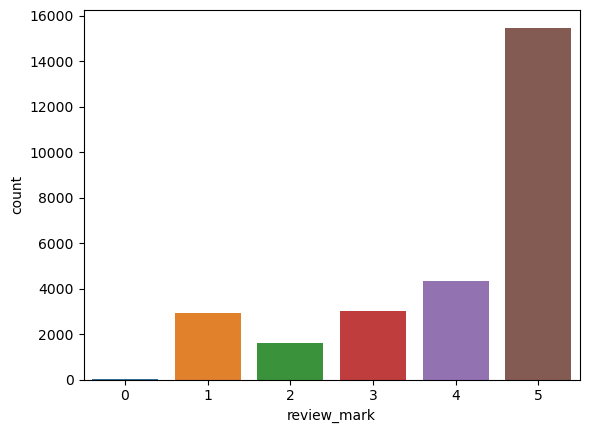

In [94]:
# распределение классов отзывов
sns.countplot(x = 'review_mark', data = df);

In [158]:
# распределение классов отзывов
df['review_mark'].value_counts()

review_mark
5    15485
4     4324
3     3013
1     2930
2     1620
0       29
Name: count, dtype: int64

## Обработка выбросов

**Ноль** среди оценок это довольно странно, нужно проверить, является ли он выбросом

In [159]:
df[df['review_mark'] == 0].sample(n=10)

,name,rating,review,review_mark,0,1,2,3,4,5,...,302,303,304,305,306,307,308,309,310,311
21046,Каретный р,4.8,"Прекрасное расположение хостела,ходила пешком ...",0,0.099041,0.081117,-0.002550,0.047040,0.003113,0.004081,...,-0.005361,0.026957,-0.004361,0.039444,-0.032132,-0.026837,-0.064677,0.001484,0.023047,-0.055581
16388,Октябрьская,4.6,"Ну, по моей системе ""звёзд"" -3,5! Интернет, ко...",0,0.077560,0.090209,-0.061399,-0.015193,0.037702,-0.044225,...,0.041969,-0.117805,-0.043619,0.045301,-0.019300,0.019922,0.016076,-0.003589,0.042437,-0.067447
3525,Холидей ИНН Москва Сокольники,5.0,Отличное расположение отеля относительно транс...,0,0.035764,0.041575,-0.074111,0.025686,-0.025298,0.021883,...,-0.018111,0.035965,0.009941,0.072949,-0.043337,0.027810,-0.004476,0.001538,0.039052,-0.049802
17899,Аэрополис,4.3,Аэрополис 3 - хорошая гостиница. Удобное распо...,0,0.097203,0.089601,-0.017354,0.030351,0.024520,0.025075,...,0.004920,0.061938,-0.024698,0.035476,-0.021027,-0.007084,-0.041904,0.042528,0.042714,-0.063627
4089,Discovery,4.9,Отличный отель.,0,-0.089863,-0.001890,0.006531,-0.006715,0.007370,0.039042,...,0.032535,0.147178,-0.052213,-0.013498,0.003881,-0.010922,-0.038159,0.082746,0.097020,-0.084927
20911,Каретный р,4.8,"Единственный плюс это расположение., было на у...",0,0.107874,0.027656,0.011323,0.004794,-0.007671,0.009962,...,-0.026353,-0.077569,-0.006529,0.049879,-0.021546,0.027372,-0.027612,-0.014768,-0.018679,-0.040801
5600,Отель Мартон ВДНХ,4.4,"Отель , в принципе, неплохой, расположен недал...",0,0.087960,0.058836,-0.015434,0.040328,-0.007853,0.013195,...,-0.000819,-0.016339,-0.013524,0.038814,-0.032349,-0.008702,-0.030965,-0.010403,-0.005726,-0.043739
1526,Арт Галакти,3.8,Неплохое место для размещения в столице недале...,0,0.078398,0.048525,-0.069510,0.032555,-0.020808,0.034220,...,0.017146,0.030351,-0.024858,0.024106,-0.048335,0.015065,-0.027696,0.036162,0.029504,-0.081894
3577,Moscow Holiday Hotel,4.5,"условия проживания вполне хорошие. Чисто, все ...",0,0.079843,0.037056,-0.058376,0.046340,0.005320,-0.024601,...,-0.017284,-0.016602,-0.012663,0.046418,-0.054798,-0.025251,-0.014432,-0.016004,0.001574,-0.037331
26923,Лабиринт,4.8,"Очень понравилось ,остановились на ночь по пут...",0,0.058248,0.021985,0.002763,0.027483,0.002664,0.024203,...,-0.038193,-0.002308,-0.013884,0.027346,-0.047828,0.003497,-0.067121,-0.068787,-0.007577,-0.010483


**Класс ноль** оказался выбросом, на это указывает: 
* Количество отзывов данного класса в сравнении с другими
* Содержание этих отзывов
* Здравый смысл

In [160]:
df = df[df['review_mark'] != 0]

## Перед обучением модели

>После *анализа данных* мы смогли выяснить, что отзывов у нас достаточно много, а вот отелей нет

Нашей **основной задачей** является предсказание рейтинга отеля на основе отзывов, рассмотрим несколько подходов:
* Предсказание оценки для каждого отзыва и последующая агрегация(может быть как простое среднее, так и что-то более сложное) результатов
* Предсказание рейтинга отеля напрямую <br>

Акцент будет сделан на **первый способ**, т.к из анализа данных мы смогли выяснить, что данных по оценкам отзывов <br>
сильно больше, это позволит сделать нашу модель более стабильной и менее склонной к переобучению, чем при **втором способе**

# Support functions

In [161]:
# используется для предсказаний на один отель
def prepared_agg_df(pred):
    pred = pred.reshape(len(pred),)
    counter_pred = Counter(pred)
    cnt_1, cnt_2, cnt_3, cnt_4, cnt_5 = counter_pred[1], counter_pred[2], counter_pred[3], counter_pred[4], counter_pred[5]
    mean_pred, median_pred = round(pred.mean(), 4), np.median(pred)
    arr = [cnt_1, cnt_2, cnt_3, cnt_4, cnt_5, mean_pred, median_pred]
    
    return arr

In [162]:
# metrics
def hotel_metrics(df, hotel_names, review_model, rating_model=None, for_each=False, print_metrics=True):
    mean_scores = []
    test_names_rating = dict(zip(df['name'], df['rating']))
    for name in hotel_names:
        cur_df = df[df['name'] == name]
        X_test_cur, y_test_cur = pd.DataFrame(cur_df['review'], columns=['review']), cur_df['review_mark']
        preds = review_model.predict(X_test_cur)
        if rating_model != None:
            agg_preds = [prepared_agg_df(preds)]
            num = rating_model.predict(agg_preds)[0]
            mean_score = min(round(num, 1), 5)
        else:
            mean_score = preds.mean()
        mean_scores.append(mean_score)
        if for_each and print_metrics:
            print(f'Accuracy_score {name}: {accuracy_score(y_test_cur, preds)}')
            print(f'F1_score {name}: {f1_score(y_test_cur, preds, average="weighted")}')
            print(f'Mean pred {name} rating: {mean_score}, real rating: {names_rating[name]}')
            print()
    
    if print_metrics:
        MAE = mean_absolute_error(list(test_names_rating.values()), mean_scores)
        MSE = mean_squared_error(list(test_names_rating.values()), mean_scores)
        RMSE = np.sqrt(MSE)
        print(f'MAE_error: {MAE}')
        print(f'MSE_error: {MSE}')
        print(f'RMSE_error: {RMSE}')
    
    return MAE, MSE, RMSE

In [163]:
# разделение данных по отелям
test_names = random.sample(list(names_rating.keys()), round(len(names_rating.keys()) * 0.2))
train_df, test_df = df[~df['name'].isin(test_names)], df[df['name'].isin(test_names)]

# Method number 1

In [164]:
X_review_train, y_review_train = pd.DataFrame(train_df['review'], columns=['review']), train_df['review_mark']

In [165]:
# данные с эмбедингами
X_review_train_embs, y_review_train_embs = train_df.drop(['name', 'rating', 'review_mark'], axis=1), train_df['review_mark']

In [166]:
all_method_one_metrics = dict()

## Build review model

In [167]:
text_features = ['review']

### SoloCatboost

In [168]:
model_cat = CatBoostClassifier(eval_metric='TotalF1', text_features=text_features, loss_function='MultiClass', 
                           task_type='GPU', auto_class_weights='SqrtBalanced')
model_cat.fit(X_review_train, y_review_train, verbose=200)

Learning rate set to 0.121305
0:	learn: 0.5371649	total: 13ms	remaining: 13s
200:	learn: 0.6455738	total: 2.1s	remaining: 8.37s
400:	learn: 0.6927129	total: 4.18s	remaining: 6.25s
600:	learn: 0.7265939	total: 6.24s	remaining: 4.14s
800:	learn: 0.7529220	total: 8.27s	remaining: 2.05s
999:	learn: 0.7738841	total: 10.2s	remaining: 0us


### Catboost with embeddings

In [169]:
model_embs = CatBoostClassifier(eval_metric='TotalF1', text_features=text_features, loss_function='MultiClass', 
                           task_type='GPU', auto_class_weights='SqrtBalanced')
model_embs.fit(X_review_train_embs, y_review_train_embs, verbose=200)

Learning rate set to 0.121305
0:	learn: 0.5386940	total: 19ms	remaining: 19s
200:	learn: 0.7261721	total: 3.15s	remaining: 12.5s
400:	learn: 0.8164289	total: 6.32s	remaining: 9.43s
600:	learn: 0.8724832	total: 9.31s	remaining: 6.18s
800:	learn: 0.9077240	total: 12.4s	remaining: 3.07s
999:	learn: 0.9333095	total: 15.3s	remaining: 0us


### Catboost for rating model

In [170]:
# кросс-валидация с одним семплом для предотвращения переобучения при создании rating модели
train_names = train_df['name'].unique().tolist()
best_model = ''
best_score = 0
df_agg = []

for train_name in train_names:
    X_train, X_test = train_df[train_df['name'] != train_name], train_df[train_df['name'] == train_name]
    X_train_cur, y_train_cur = pd.DataFrame(X_train['review'], columns=['review']), X_train['review_mark']
    X_test_cur, y_test_cur = pd.DataFrame(X_test['review'], columns=['review']), X_test['review_mark']

    model = CatBoostClassifier(eval_metric='TotalF1', text_features=text_features, loss_function='MultiClass', 
                           task_type='GPU', auto_class_weights='SqrtBalanced')
    model.fit(X_train_cur, y_train_cur, verbose=0)

    if model.best_score_['learn']['TotalF1'] > best_score:
        best_score = model.best_score_['learn']['TotalF1']
        best_model = model

    pred = model.predict(X_test_cur)
    df_agg.append(prepared_agg_df(pred) + [names_rating[train_name]])

new_df = pd.DataFrame(df_agg, 
                           columns=['cnt_1', 'cnt_2', 'cnt_3', 'cnt_4', 'cnt_5',
                                    'mean_pred', 'median_pred','rating'])

In [171]:
new_df.head()

,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5,mean_pred,median_pred,rating
0,13,3,21,81,382,4.6320,5.0,5.0
1,33,22,89,126,227,3.9899,4.0,4.3
2,64,7,17,33,379,4.3120,5.0,5.0
3,120,22,55,63,239,3.5591,4.0,4.2
4,59,19,50,60,212,3.8675,5.0,4.4


## Build rating model

In [172]:
X_rating_train, y_rating_train = new_df.drop(['rating'], axis=1), new_df['rating']

### Simple mean

In [181]:
MAE, MSE, RMSE = hotel_metrics(test_df, test_names, model_cat)
all_method_one_metrics['rating_mean'] = [MAE, MSE, RMSE]

MAE_error: 0.8759390477777197
MSE_error: 1.1485306739144479
RMSE_error: 1.0716952336902725


### Rating catboost

In [180]:
from catboost import CatBoostRegressor
cat_reg = CatBoostRegressor(eval_metric='RMSE')
cat_reg.fit(X_rating_train, y_rating_train, verbose=100)
MAE, MSE, RMSE = hotel_metrics(test_df, test_names, model_cat, rating_model=cat_reg)
all_method_one_metrics['rating_cat'] = [MAE, MSE, RMSE]

Learning rate set to 0.025505
0:	learn: 0.3495329	total: 759us	remaining: 758ms
100:	learn: 0.1370045	total: 37.4ms	remaining: 333ms
200:	learn: 0.0839708	total: 72.9ms	remaining: 290ms
300:	learn: 0.0549572	total: 109ms	remaining: 253ms
400:	learn: 0.0393751	total: 144ms	remaining: 215ms
500:	learn: 0.0274758	total: 180ms	remaining: 180ms
600:	learn: 0.0191786	total: 219ms	remaining: 145ms
700:	learn: 0.0140791	total: 256ms	remaining: 109ms
800:	learn: 0.0102776	total: 295ms	remaining: 73.2ms
900:	learn: 0.0078874	total: 333ms	remaining: 36.6ms
999:	learn: 0.0057147	total: 373ms	remaining: 0us
MAE_error: 0.5615384615384618
MSE_error: 0.5300000000000001
RMSE_error: 0.7280109889280519


### Linear rating models

In [182]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_rating_train, y_rating_train)
MAE, MSE, RMSE = hotel_metrics(test_df, test_names, model_cat, rating_model=linear_model)
all_method_one_metrics['rating_linear'] = [MAE, MSE, RMSE]

MAE_error: 0.653846153846154
MSE_error: 0.7269230769230771
RMSE_error: 0.8525978400882078


In [183]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=0.2)
ridge_model.fit(X_rating_train, y_rating_train)
MAE, MSE, RMSE = hotel_metrics(test_df, test_names, model_cat, rating_model=ridge_model)
all_method_one_metrics['rating_ridge'] = [MAE, MSE, RMSE]

MAE_error: 0.653846153846154
MSE_error: 0.7284615384615386
RMSE_error: 0.8534995831642442


# Method number 2

In [139]:
embs_feats = list(map(str, [i for i in range(312)]))
mean_embeddings_train = train_df.groupby('name').agg(
    **{f'average_emb_{i}': (f'{i}', 'mean') for i in range(312)},
    average_rating=('rating', 'mean')).reset_index()

In [140]:
X_rating_train_embs, y_rating_train_embs = mean_embeddings_train[[f'average_emb_{i}' for i in range(312)]], mean_embeddings_train['average_rating']

## Catboost

In [141]:
cat_rating_embs = CatBoostRegressor(eval_metric='RMSE', task_type='GPU')
cat_rating_embs.fit(X_rating_train_embs, y_rating_train_embs, verbose=200)

Learning rate set to 0.027282
0:	learn: 0.3494103	total: 10.2ms	remaining: 10.2s
200:	learn: 0.0513955	total: 1.85s	remaining: 7.38s
400:	learn: 0.0263439	total: 3.71s	remaining: 5.55s
600:	learn: 0.0172376	total: 5.69s	remaining: 3.78s
800:	learn: 0.0117291	total: 7.49s	remaining: 1.86s
999:	learn: 0.0088834	total: 9.37s	remaining: 0us


# Test

## Method 1

In [142]:
X_review_test, y_review_test = pd.DataFrame(test_df['review'], columns=['review']), test_df['review_mark']

In [143]:
X_review_test_embs, y_review_test_embs = test_df.drop(['name', 'rating', 'review_mark'], axis=1), test_df['review_mark']

In [173]:
preds = model_cat.predict(X_review_test)

In [174]:
MAE, MSE, RMSE = hotel_metrics(test_df, test_names, model_cat, rating_model=cat_reg, for_each=True, print_metrics=True)

Accuracy_score Исаевск: 0.682
F1_score Исаевск: 0.69079737959656
Mean pred Исаевск rating: 4.6, real rating: 4.9

Accuracy_score Максима Славия: 0.74
F1_score Максима Славия: 0.7357732099171139
Mean pred Максима Славия rating: 4.9, real rating: 4.6

Accuracy_score Suleiman Palace Hotel: 0.766
F1_score Suleiman Palace Hotel: 0.7655546267740966
Mean pred Suleiman Palace Hotel rating: 4.9, real rating: 4.8

Accuracy_score Номера на Япее: 0.6131386861313869
F1_score Номера на Япее: 0.61686737689839
Mean pred Номера на Япее rating: 4.2, real rating: 4.2

Accuracy_score Valo Business: 0.8056112224448898
F1_score Valo Business: 0.8263183556215868
Mean pred Valo Business rating: 5.0, real rating: 5.0

Accuracy_score Янр: 0.6876310272536688
F1_score Янр: 0.6822717174770133
Mean pred Янр rating: 4.6, real rating: 4.3

Accuracy_score Апартаменты Восх: 0.63
F1_score Апартаменты Восх: 0.6059029771398193
Mean pred Апартаменты Восх rating: 4.0, real rating: 3.4

Accuracy_score Amici Grand Hotel: 0.71

In [177]:
print(accuracy_score(y_review_test, preds))
print(f1_score(y_review_test, preds, average='weighted'))
print(classification_report(y_review_test, preds, target_names=['0', '1', '2', '3', '4', '5']))

0.6950438300741739
0.689064453626799
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.59      0.74      0.66       671
           2       0.31      0.17      0.22       364
           3       0.36      0.38      0.37       671
           4       0.46      0.45      0.45       933
           5       0.88      0.88      0.88      3287

    accuracy                           0.70      5932
   macro avg       0.43      0.44      0.43      5932
weighted avg       0.69      0.70      0.69      5932



In [184]:
all_method_one_metrics

{'rating_cat': [0.5615384615384618, 0.5300000000000001, 0.7280109889280519],
 'rating_mean': [0.8759390477777197, 1.1485306739144479, 1.0716952336902725],
 'rating_linear': [0.653846153846154, 0.7269230769230771, 0.8525978400882078],
 'rating_ridge': [0.653846153846154, 0.7284615384615386, 0.8534995831642442]}

## Method 2

In [185]:
# подготовка данных
embs_feats = list(map(str, [i for i in range(312)]))
mean_embeddings_test = test_df.groupby('name').agg(
    **{f'average_emb_{i}': (f'{i}', 'mean') for i in range(312)},
    average_rating=('rating', 'mean')).reset_index()

In [194]:
test_names_rating = dict(zip(test_df['name'], test_df['rating']))

In [205]:
mean_scores = cat_rating_embs.predict(mean_embeddings_test.drop(['name', 'average_rating'], axis=1))
true_values = list(test_names_rating.values())
MAE = mean_absolute_error(true_values, mean_scores)
MSE = mean_squared_error(true_values, mean_scores)
RMSE = np.sqrt(MSE)
print(f'MAE_error: {MAE}')
print(f'MSE_error: {MSE}')
print(f'RMSE_error: {RMSE}')

MAE_error: 0.5413500526835688
MSE_error: 0.5279642987790549
RMSE_error: 0.7266115184739744


In [206]:
for indx, name in enumerate(test_names_rating.keys()):
    print(f'Mean pred {name} rating: {mean_scores[indx]}, real rating: {test_names_rating[name]}')

Mean pred Suleiman Palace Hotel rating: 4.694443953009319, real rating: 4.8
Mean pred Ibis rating: 4.5011942428880225, real rating: 5.0
Mean pred Максима Славия rating: 4.893925162890028, real rating: 4.6
Mean pred Amici Grand Hotel rating: 4.904645041360709, real rating: 4.9
Mean pred Апартаменты Восх rating: 4.729626452757429, real rating: 3.4
Mean pred Янр rating: 4.176805627425956, real rating: 4.3
Mean pred Valo Business rating: 4.1496401597164905, real rating: 5.0
Mean pred Carat by Undersun rating: 4.57975036290266, real rating: 4.6
Mean pred Исаевск rating: 4.162184644550511, real rating: 4.9
Mean pred Байкал 2* rating: 4.825795187169501, real rating: 3.2
Mean pred Номера на Япее rating: 4.395513399999405, real rating: 4.2
Mean pred Фи rating: 4.1475744067334475, real rating: 3.5
Mean pred Ладомир rating: 4.604490024468834, real rating: 4.0


# **Выводы**

> Мы попробовали два подхода для получения рейтинга отеля на основе отзывов <br>
По метрикам метод два показал себя лучше, но при детальном анализе видно что на самом деле это не так, <br>
модель довольно не стабильна, в отличии от первого подхода

**Возможные улушения:**
* Собрать большее количество уникальных отелей
* Обучить модель архитектуры трансформер на отзывах для более точных эмбедингов
* Попробовать ансамблирование моделей для большей устойчивости